In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def display_image(title, image, cmap='gray'):
    plt.figure(figsize=(10, 8))
    plt.title(title)
    plt.imshow(image, cmap=cmap)
    plt.axis('off')
    plt.show()

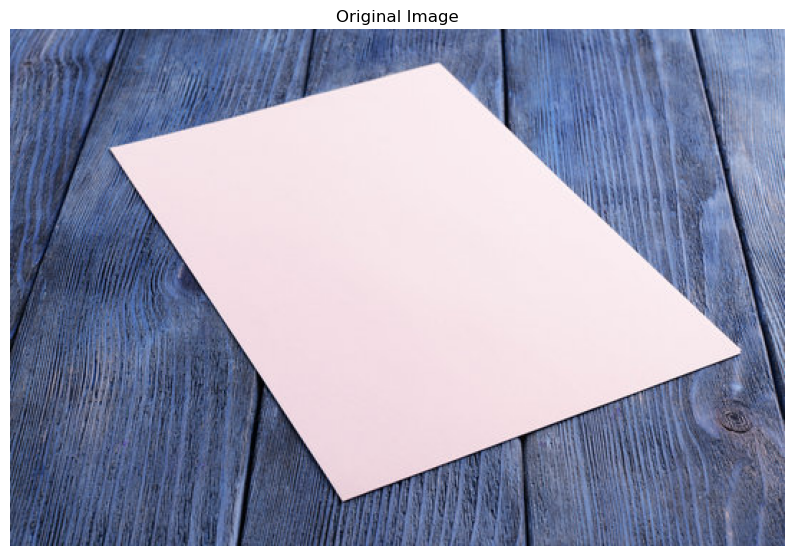

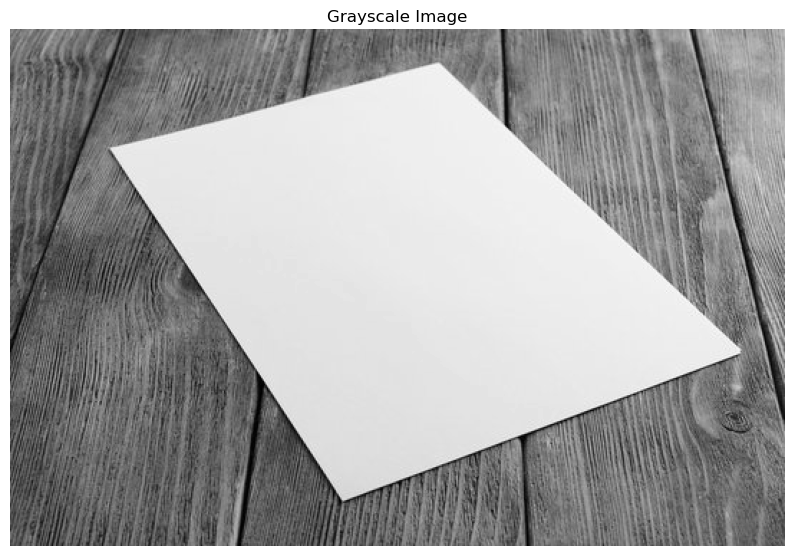

In [13]:
# Step 1: Import and Preprocess the Image
img = cv2.imread('./raw_dataset/img5.jpg')
if img is None:
    raise FileNotFoundError(f"Image not found at {'./raw_dataset/img4.jpg'}")
image = img.copy()

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Display Original and Grayscale Image
display_image("Original Image", image, cmap='viridis')
display_image("Grayscale Image", gray)

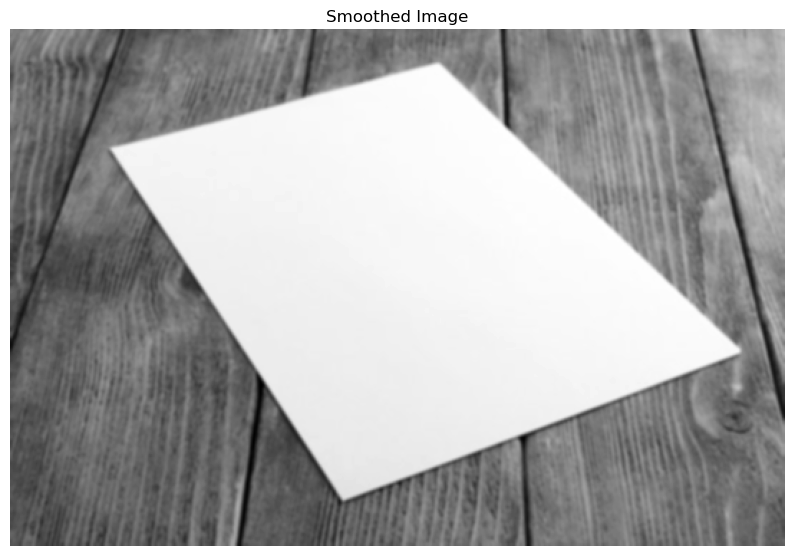

In [14]:
# Noise Reduction
smoothed = cv2.GaussianBlur(gray, (5, 5), 0)
display_image("Smoothed Image", smoothed)

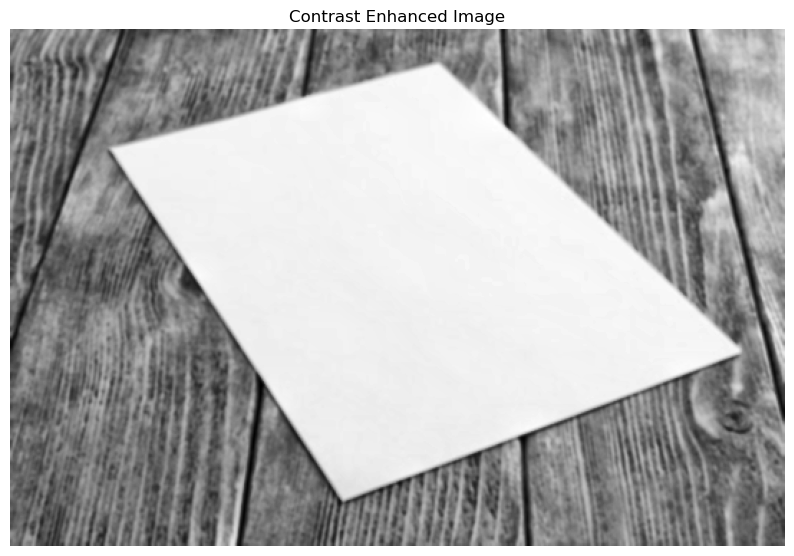

In [15]:
# Adaptive Histogram Equalization
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(20, 20))
enhanced = clahe.apply(smoothed)
display_image("Contrast Enhanced Image", enhanced)

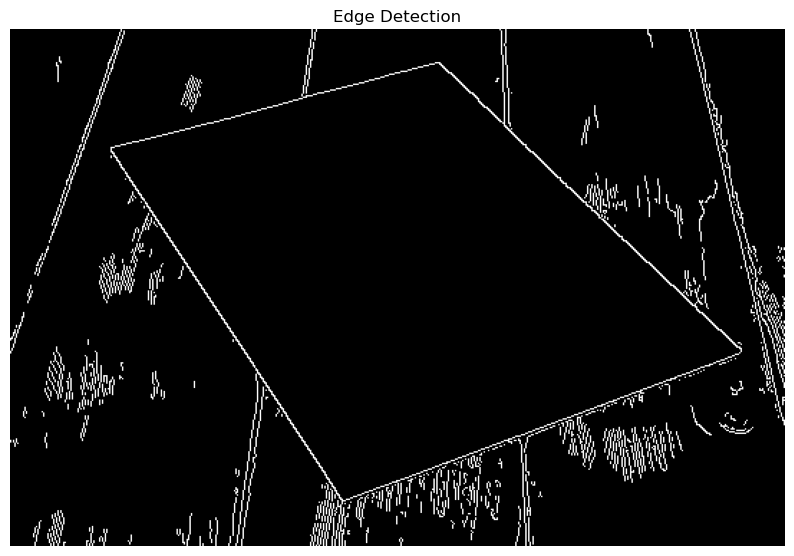

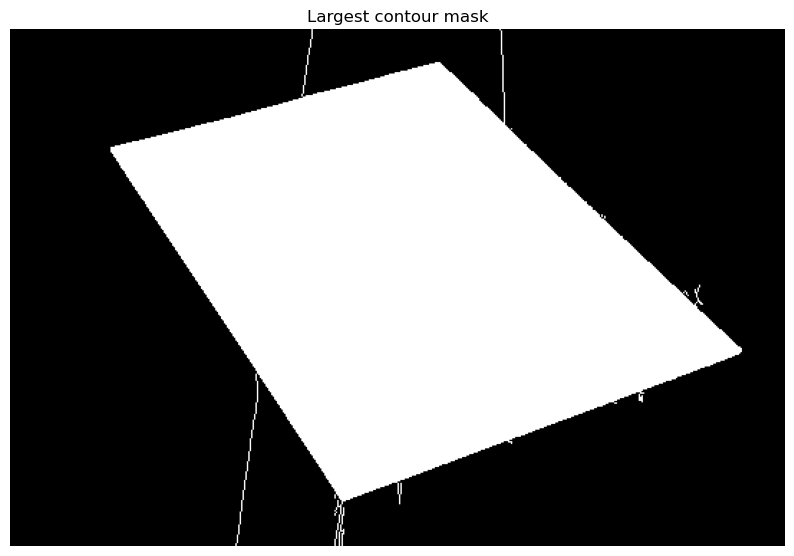

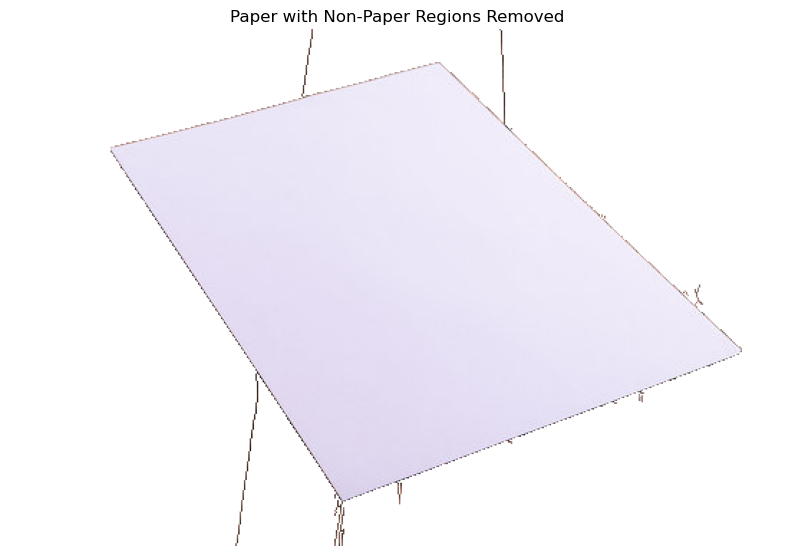

In [16]:
# Step 2: Remove Non-Paper Regions

gray = cv2.bilateralFilter(gray, 20, 30, 30)
#gray = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
edges = cv2.Canny(gray, 100, 150) # The thresholds 50 and 150 define how sensitive the edge detection is to gradients.
display_image("Edge Detection", edges)

contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:1]
largest_contour = max(contours, key=cv2.contourArea)

# Create a mask for the largest contour
mask = np.zeros_like(gray)
cv2.drawContours(mask, [largest_contour], -1, (255), thickness=cv2.FILLED)

display_image("Largest contour mask", cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))

# Replace non-paper regions with white
paper_only = cv2.bitwise_and(image, image, mask=mask)
paper_only[np.where(mask == 0)] = [255, 255, 255]  # Set non-paper regions to white

display_image("Paper with Non-Paper Regions Removed", cv2.cvtColor(paper_only, cv2.COLOR_BGR2RGB))

# Convert to grayscale again for further processing
gray_paper_only = cv2.cvtColor(paper_only, cv2.COLOR_BGR2GRAY)

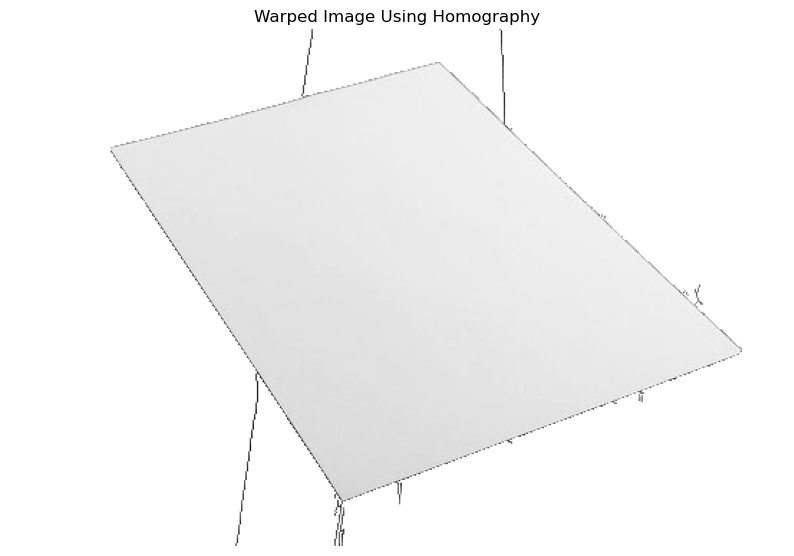

In [17]:
# Step 3: Deskew and Straighten Using Homography
epsilon = 0.02 * cv2.arcLength(largest_contour, True)
paper_approx = cv2.approxPolyDP(largest_contour, epsilon, True)

# Sort the src_pts to ensure they are in the correct order
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    print(s)
    rect[0] = pts[np.argmin(s)]  # Top-left
    rect[2] = pts[np.argmax(s)]  # Bottom-right
    
    diff = np.diff(pts, axis=1)
    
    rect[1] = pts[np.argmin(diff)]  # Top-right
    rect[3] = pts[np.argmax(diff)]  # Bottom-left
    return rect

if len(paper_approx) == 4:
    # Define the source points (corners of the detected paper)
    src_pts = np.float32([paper_approx[i][0] for i in range(4)])
    
    src_pts = order_points(src_pts)
    
    # Compute the destination points (aligned rectangle)
    # Ensure the order of points matches (top-left, top-right, bottom-right, bottom-left)
    width = max(
        np.linalg.norm(src_pts[0] - src_pts[1]),  # Top edge
        np.linalg.norm(src_pts[2] - src_pts[3])   # Bottom edge
    )
    height = max(
        np.linalg.norm(src_pts[0] - src_pts[3]),  # Left edge
        np.linalg.norm(src_pts[1] - src_pts[2])   # Right edge
    )
    dst_pts = np.array([
        [0, 0],
        [width - 1, 0],
        [width - 1, height - 1],
        [0, height - 1]
    ], dtype="float32")
    
    # Compute the homography matrix
    h_matrix, _ = cv2.findHomography(src_pts, dst_pts)
    
    # Apply the homography transformation
    warped = cv2.warpPerspective(gray_paper_only, h_matrix, (int(width), int(height)))
else:
    warped = gray_paper_only

display_image("Warped Image Using Homography", warped)

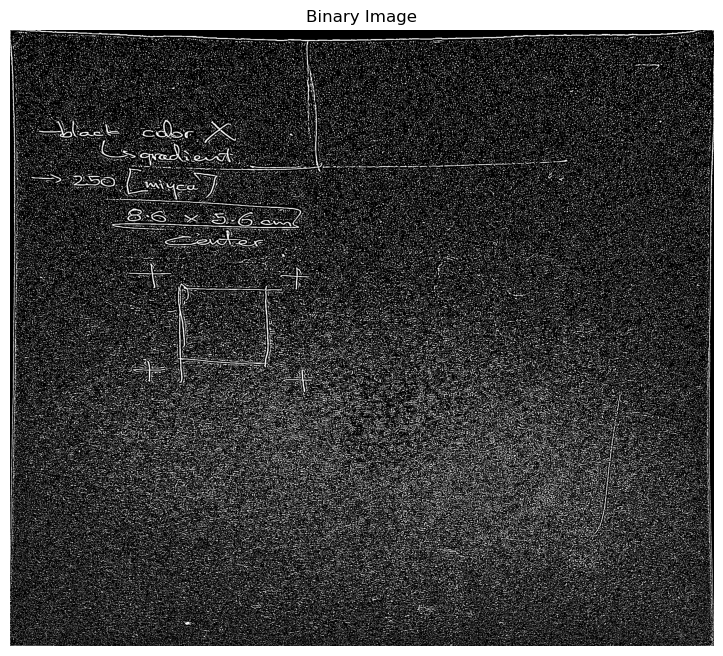

In [13]:
# Step 3: Segment the Braille Characters
binary = cv2.adaptiveThreshold(warped, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)
display_image("Binary Image", binary)

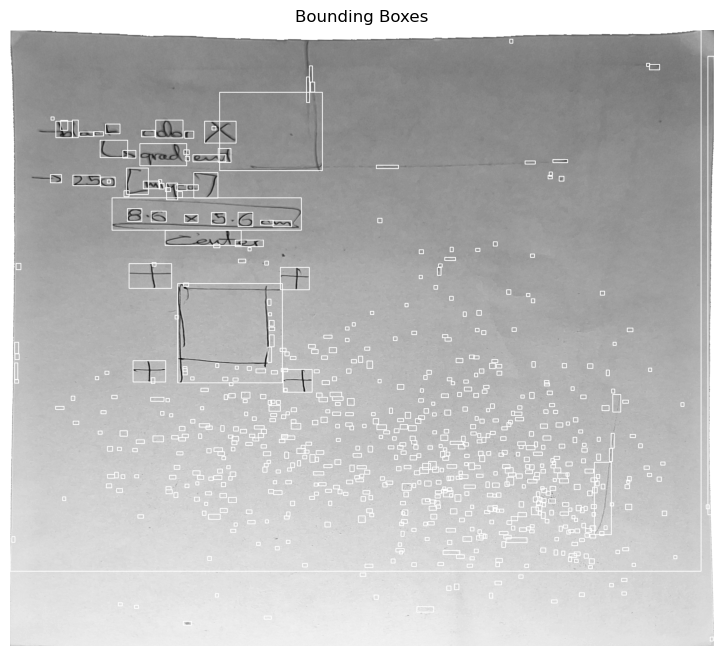

In [17]:
dot_contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter and Display Contours
output = warped.copy()
min_width, min_height = 10, 10  # Adjust based on Braille dot size
cropped_images = []

for contour in dot_contours:
    x, y, w, h = cv2.boundingRect(contour)
    if w > min_width and h > min_height:
        cv2.rectangle(output, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cropped = warped[y:y + h, x:x + w]
        cropped_images.append(cropped)

# Display the image with bounding boxes
display_image("Bounding Boxes", output)